### Import Modules

In [1]:
import gensim
from gensim.test.utils import common_texts
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile
from gensim.models import LsiModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel
from collections import defaultdict

# sklearn implements t-SNE.
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Import seaborn and matplotlib.patheffects to make nice plots.
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

### Functions for interpretation

In [2]:
def format_topics_sentences(model, corpus, texts):
    # Init output
    term_doc_reduced = []
    sent_topics_df = pd.DataFrame()
    print("Getting main topic for document...")
    for i, row in enumerate(model[corpus]):
        if i % 1000 == 0: print(i,end='  ')
        if len(row) > 0:
            if type(row[0]) == list: row = row[0]
        else:
            continue
        topic_num, prop_topic = row[np.argmax([perc for topic, perc in row])]
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        wp = model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, texts[i]]).reset_index(drop=True), ignore_index=True)
        term_doc_reduced.append(corpus[i])
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Keywords', 'Review']

    return(sent_topics_df, term_doc_reduced)

def find_most_representative_doc_for_each_doc(df_topic_sents_keywords, df):
    num_topics = df_topic_sents_keywords.Dominant_Topic.nunique()
    max_percs = df_topic_sents_keywords.groupby(['Dominant_Topic']).max().Perc_Contribution
    mask = df_topic_sents_keywords.apply(lambda x: (x.Dominant_Topic, x.Perc_Contribution) in zip(range(num_topics), max_percs), axis = 1)
    sent_topics_sorteddf = df_topic_sents_keywords.loc[mask, :].sort_values('Dominant_Topic')
    indices = df_topic_sents_keywords.loc[mask, :].sort_values('Dominant_Topic').index.values
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf.reset_index(drop=True), df.iloc[indices, :].loc[:, ['star_rating', 'helpful_votes', 'total_votes', 'review']].reset_index(drop=True)], axis = 1)
    sent_topics_sorteddf.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'bag_of_words', 'star_rating', 'helpful_votes', 'total_votes', 'review']
    # Show
    return sent_topics_sorteddf.drop('bag_of_words', axis = 1)

def topic_distribution_across_docs(df_topic_sents_keywords):
    # Number of Documents for Each Topic
    topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

    # Percentage of Documents for Each Topic
    topic_contribution = round(topic_counts/topic_counts.sum(), 4)

    # Topic Number and Keywords
    topic_num_keywords = df_topic_sents_keywords.groupby('Dominant_Topic').max().reset_index()[['Dominant_Topic', 'Keywords']]

    # Concatenate Column wise
    df_dominant_topic = pd.concat([topic_num_keywords.reset_index(drop=True), 
                                   topic_counts.reset_index(drop=True), 
                                   topic_contribution.reset_index(drop=True)], axis=1)

    # Change Column names
    df_dominant_topic.columns = ['Dominant_Topic', 'Keywords', 'Num_Documents', 'Perc_Documents']
    
    return df_dominant_topic

def scatter(x, colors):
    """
    From https://github.com/thisismetis/sf20_ds19/blob/master/curriculum/project-04/svd-pca/PCA_digits.ipynb
    
    """
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [3]:
data_lemmatized = pd.read_pickle('./preprocessed_data/data_lemmatized.pkl')
dictionary = pd.read_pickle('./preprocessed_data/dictionary.pkl')
term_doc = pd.read_pickle('./preprocessed_data/term_doc.pkl')
tf_idf = pd.read_pickle('./preprocessed_data/tf_idf.pkl')
df = pd.read_pickle('raw_data/netflix.pkl')

### NMF

In [4]:
nmf = Nmf(term_doc, num_topics=10, kappa=0.005, eval_every=1000, id2word = dictionary, random_state = 100)

In [5]:
coherence_model = CoherenceModel(model=nmf, texts=data_lemmatized, dictionary=dictionary, coherence='c_npmi')
coherence_model.get_coherence()

-0.07839177485387225

In [6]:
df_topic_sents_keywords, term_doc_reduced = format_topics_sentences(nmf, corpus=term_doc, texts=data_lemmatized)

Getting main topic for document...
0  1000  2000  3000  4000  5000  6000  7000  8000  9000  10000  11000  12000  

##### Topics are not easily distinguishable from each other

In [7]:
df_topic_sents_keywords.groupby('Dominant_Topic').min().loc[:, 'Keywords'].values

array(['app, service, issue, time, problem, movie, video, tv_show, work, year',
       'app, movie, time, problem, love, account, fire, tv, tablet, show',
       'love, app, video, movie, device, time, title, fire, day, service',
       'time, issue, show, movie, problem, account, service, app, video, option',
       'movie, problem, time, app, tv_show, love, service, fire, watch, issue',
       'app, movie, video, love, time, problem, device, thing, update, issue',
       'movie, love, time, service, season, show, problem, tv_show, app, watch',
       'movie, time, device, app, love, video, problem, tv_show, account, tv',
       'app, love, service, movie, video, fire, device, screen, time, kindle'],
      dtype=object)

In [8]:
sum(np.isnan(df_topic_sents_keywords.Dominant_Topic.values))

0

In [9]:
len(df_topic_sents_keywords)

10251

In [10]:
term_doc_matrix = gensim.matutils.corpus2csc(term_doc_reduced).toarray().T

In [11]:
%time term_doc_tsne = TSNE(random_state=100).fit_transform(term_doc_matrix)

CPU times: user 23min 55s, sys: 8.94 s, total: 24min 4s
Wall time: 16min 21s


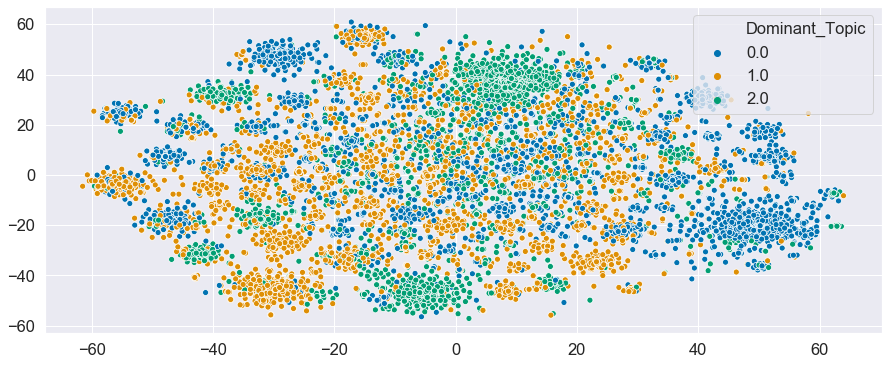

In [12]:
plt.figure(figsize=(15,6))
s=sns.scatterplot(term_doc_tsne[:,0], term_doc_tsne[:,1], hue=df_topic_sents_keywords.Dominant_Topic, palette='colorblind')
# s.legend_.remove()

### LSA model

In [13]:
lsa_model = LsiModel(term_doc, num_topics= 9, id2word = dictionary)

In [14]:
df_topic_sents_keywords_lsa, term_doc_reduced_lsa = format_topics_sentences(model=lsa_model, corpus=term_doc, texts=data_lemmatized)
sum(np.isnan(df_topic_sents_keywords_lsa.Dominant_Topic.values))
len(df_topic_sents_keywords_lsa)

Getting main topic for document...
0  1000  2000  3000  4000  5000  6000  7000  8000  9000  10000  11000  12000  

10251

##### Topics have many overlapping keywords

In [15]:
df_topic_sents_keywords_lsa.groupby('Dominant_Topic').min().loc[:, 'Keywords'].values

array(['movie, app, time, subtitle, video, issue, problem, way, device, love',
       'movie, app, time, subtitle, video, issue, problem, way, device, update',
       'love, subtitle, app, movie, time, android, season, video, way, program',
       'app, subtitle, time, android, device, problem, computer, box, window, background',
       'app, problem, time, service, subtitle, device, tv, work, video, fire',
       'time, problem, app, video, subtitle, tv, issue, device, computer, way',
       'service, video, problem, tv, time, fire, selection, month, content, program',
       'video, problem, fire, service, tv, time, app, thing, device, update',
       'service, problem, tv, device, fire, work, tablet, issue, thing, video'],
      dtype=object)

In [16]:
term_doc_matrix_lsa = gensim.matutils.corpus2csc(term_doc_reduced_lsa).toarray().T

In [17]:
%time term_doc_tsne_lsa_6 = TSNE(random_state=100).fit_transform(term_doc_matrix_lsa)

CPU times: user 23min 6s, sys: 8.29 s, total: 23min 14s
Wall time: 15min 37s


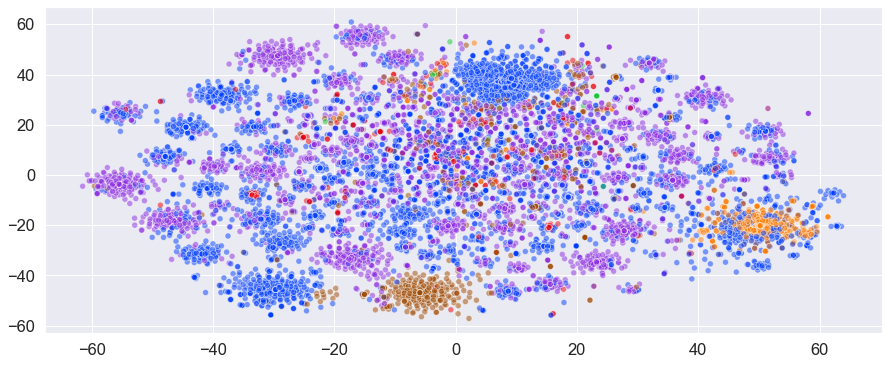

In [18]:
plt.figure(figsize=(15,6))
s=sns.scatterplot(term_doc_tsne_lsa_6[:,0], term_doc_tsne_lsa_6[:,1], hue=df_topic_sents_keywords_lsa.Dominant_Topic, palette='bright', alpha=0.5)
s.legend_.remove()